# <font color='green'>Business Analytics e Machine Learning Para Projetos Econômicos</font>
### <font color='green'>Análise de Sentimento Econômico no Brasil com Machine Learning</font>

Este projeto de Business Analytics e Machine Learning tem como foco a Análise de Sentimento Econômico no Brasil, utilizando técnicas de aprendizado de máquina. A área de Finanças, por sua abrangência, oferece diversas possibilidades de aplicação, sendo possível desenvolver dezenas ou até centenas de projetos distintos.

Neste contexto, será utilizado um conjunto de dados fictício contendo frases rotuladas sobre a economia brasileira, a partir do qual serão realizadas as seguintes etapas:

- Ajuste fino de modelos de machine learning;

- Tokenização dos textos;

- Avaliação de desempenho dos modelos;

- Deploy em uma aplicação web, com geração de gráficos interativos e funcionalidade de histórico de consultas (código no arquivo `app_web_sentimento.py` ).

<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
## Instalando e Carregando Pacotes

In [1]:
# Imports
# Biblioteca para impressão colorida e elegante no terminal
import rich

# Biblioteca principal para computação com tensores e deep learning
import torch

# Detecta automaticamente o idioma de um texto
import langid

# Biblioteca de machine learning com ferramentas como classificação, regressão, etc.
import sklearn

# Biblioteca com datasets prontos para uso e ferramentas de NLP
import datasets

# Biblioteca da Hugging Face com modelos e tokenizadores de NLP
import transformers

# Biblioteca para manipulação de dados em formato de tabela (DataFrames)
import pandas as pd

# Biblioteca para operações numéricas e manipulação de arrays
import numpy as np

# Função do sklearn para dividir os dados em treino e teste
from sklearn.model_selection import train_test_split

# Importa o tokenizador e o modelo BERT para classificação de texto
from transformers import BertTokenizer, BertForSequenceClassification

# Ferramentas da Hugging Face para treinar modelos
from transformers import Trainer, TrainingArguments

# Adiciona padding automático aos dados de entrada durante o treino
from transformers import DataCollatorWithPadding

# Métricas de avaliação do sklearn para classificação
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Converte dados para o formato Dataset da Hugging Face
from datasets import Dataset

# Exibe barra de progresso estilizada com a biblioteca rich
from rich.progress import track

# Desativa avisos para evitar poluição visual no output
import warnings
warnings.filterwarnings('ignore')

/home/edemilson/dev/brasil-economico-sentiment-ml/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configura o pandas para mostrar o conteúdo completo das colunas, sem cortar o texto
pd.set_option('max_colwidth', None)

## Carregando e Compreendendo os Dados

In [3]:
# Carrega o dataset
df = pd.read_csv('dataset.csv')

In [4]:
# Shape
df.shape

(138, 4)

In [5]:
# Amostra
df.head()

,ID,Data,texto,sentimento
0,0,2024-07-01,O Brasil tem demonstrado resiliência econômica frente aos desafios globais.,Positivo
1,1,2024-07-01,"Investimentos estrangeiros crescem constantemente no país, reforçando a confiança internacional.",Positivo
2,2,2024-07-01,O agronegócio brasileiro se destaca globalmente pela produtividade e inovação.,Positivo
3,3,2024-07-01,O setor de energia renovável do Brasil é referência em sustentabilidade.,Positivo
4,4,2024-07-01,A inovação tecnológica impulsiona o crescimento econômico em diversas regiões brasileiras.,Positivo


In [6]:
# Contagem de registros por classe
sentiment_count = df['sentimento'].value_counts()

In [7]:
print(sentiment_count)

sentimento
Positivo    50
Negativo    48
Neutro      40
Name: count, dtype: int64


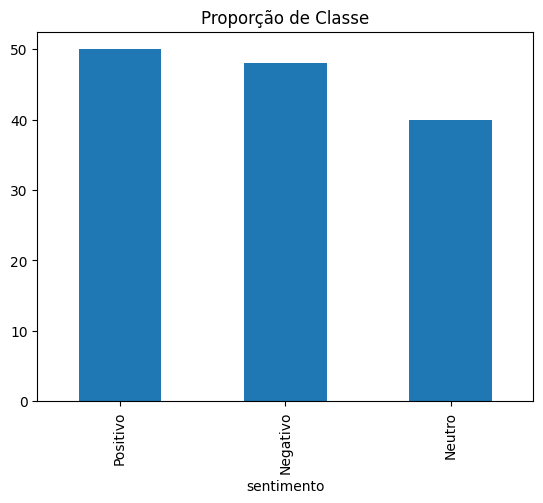

In [8]:
# Visualizando a proporção de classes
df['sentimento'].value_counts().plot(kind = 'bar', title = 'Proporção de Classe');

## Detecção Automática de Idioma dos Dados

In [9]:
# Cria uma nova coluna no dataframe
df['lang'] = None

In [10]:
# Amostra
df.head()

,ID,Data,texto,sentimento,lang
0,0,2024-07-01,O Brasil tem demonstrado resiliência econômica frente aos desafios globais.,Positivo,None
1,1,2024-07-01,"Investimentos estrangeiros crescem constantemente no país, reforçando a confiança internacional.",Positivo,None
2,2,2024-07-01,O agronegócio brasileiro se destaca globalmente pela produtividade e inovação.,Positivo,None
3,3,2024-07-01,O setor de energia renovável do Brasil é referência em sustentabilidade.,Positivo,None
4,4,2024-07-01,A inovação tecnológica impulsiona o crescimento econômico em diversas regiões brasileiras.,Positivo,None


In [11]:
# Loop para percorrer cada linha do DataFrame e detectar o idioma do texto
for index, row in track(df.iterrows(), total = len(df)):
    
    # Extrai o texto da coluna 'texto' da linha atual
    text = row['texto']
    
    # Verifica se o texto é uma string válida
    if isinstance(text, str):
        
        # Classifica o idioma do texto e obtém a confiança da classificação
        language, confidence = langid.classify(text)
        
        # Atribui o idioma detectado à coluna 'lang' no DataFrame
        df.at[index, 'lang'] = language
    else:
        
        # Se o texto não for uma string válida, marca o idioma como 'desconhecido'
        df.at[index, 'lang'] = 'desconhecido'

In [12]:
# Amostra
df.sample(10)

,ID,Data,texto,sentimento,lang
33,33,2024-07-01,Setores como saúde e educação têm atraído investimentos significativos recentemente.,Positivo,pt
53,53,2024-07-01,"O déficit fiscal segue preocupante, limitando investimentos essenciais.",Negativo,pt
56,56,2024-07-01,O crescimento econômico permanece abaixo das expectativas há anos.,Negativo,pt
137,137,2024-07-01,Diversos setores econômicos brasileiros passam por ciclos anuais previsíveis.,Neutro,pt
82,82,2024-07-01,Instabilidade econômica reduz o interesse de investidores internacionais.,Negativo,pt
30,30,2024-07-01,O crescimento sustentável é uma prioridade cada vez maior nas políticas econômicas brasileiras.,Positivo,pt
64,64,2024-07-01,Problemas no sistema de saúde pública geram altos custos sociais e econômicos.,Negativo,pt
84,84,2024-07-01,O atraso em reformas estruturantes prejudica o desempenho econômico.,Negativo,pt
85,85,2024-07-01,Dificuldades econômicas têm levado a um aumento da pobreza e desigualdade.,Negativo,pt
15,15,2024-07-01,A crescente inclusão financeira impulsiona novos negócios e serviços no país.,Positivo,pt


## Limpeza dos Dados

In [13]:
# Vamos usar somente registros com texto detectado como português
df = df[df['lang'] == 'pt']

In [14]:
# Shape
df.shape

(130, 5)

In [15]:
# Aplica expressão regular para limpar o texto
df['texto'] = df['texto'].str.replace(r'http\S+', '', regex=True).str.replace(r'#\w+', '', regex=True).str.replace(r'@\w+', '', regex=True).str.replace(r'\d+', '', regex=True)         

### Explicação detalhada das transformações aplicadas ao texto com expressões regulares

**`df['texto'].str.replace(r'http\S+', '', regex=True)`**

- **Objetivo:** Remove todas as URLs do texto.
- **Expressão Regular:** `http\S+`  
  - `http`: Localiza qualquer trecho que inicie com "http".  
  - `\S+`: Corresponde a qualquer sequência de caracteres que não contenha espaços (representando o restante da URL).
- **Resultado:** URLs completas como `http://exemplo.com` são eliminadas do conteúdo textual.

---

**`str.replace(r'#\w+', '', regex=True)`**

- **Objetivo:** Remove hashtags do texto.
- **Expressão Regular:** `#\w+`  
  - `#`: Identifica o caractere de hashtag.  
  - `\w+`: Corresponde a uma sequência de caracteres alfanuméricos (letras, números ou underscore).
- **Resultado:** Hashtags como `#Economia` são removidas do texto.

---

**`str.replace(r'@\w+', '', regex=True)`**

- **Objetivo:** Remove menções a usuários.
- **Expressão Regular:** `@\w+`  
  - `@`: Identifica o símbolo de arroba.  
  - `\w+`: Corresponde ao nome de usuário (sequência alfanumérica).
- **Resultado:** Menções como `@usuario123` são removidas do conteúdo.

---

**`str.replace(r'\d+', '', regex=True)`**

- **Objetivo:** Remove todos os números do texto.
- **Expressão Regular:** `\d+`  
  - `\d+`: Corresponde a uma ou mais ocorrências de dígitos numéricos.
- **Resultado:** Números como `2023` ou `123` são eliminados do texto.

In [16]:
# Mapeamento de sentimento para valor numérico
sentiment_mapping = {'Negativo': 0, 'Neutro': 1, 'Positivo': 2}

In [17]:
# Aplica o mapeamento e cria uma nova coluna
df['label'] = df['sentimento'].map(sentiment_mapping)

In [18]:
# Amostra
df.sample(10)

,ID,Data,texto,sentimento,lang,label
99,99,2024-07-01,A economia brasileira é fortemente influenciada por commodities.,Neutro,pt,1
102,102,2024-07-01,A inflação brasileira oscila conforme políticas econômicas adotadas.,Neutro,pt,1
110,110,2024-07-01,A infraestrutura logística brasileira é ampla e diversificada.,Neutro,pt,1
64,64,2024-07-01,Problemas no sistema de saúde pública geram altos custos sociais e econômicos.,Negativo,pt,0
115,115,2024-07-01,Diversas agências avaliam regularmente a economia brasileira.,Neutro,pt,1
78,78,2024-07-01,Altas taxas de juros prejudicam o crédito e o crescimento econômico.,Negativo,pt,0
49,49,2024-07-01,"O mercado consumidor brasileiro continua atraindo empresas internacionais, impulsionando a economia interna.",Positivo,pt,2
15,15,2024-07-01,A crescente inclusão financeira impulsiona novos negócios e serviços no país.,Positivo,pt,2
93,93,2024-07-01,Baixa eficiência do setor público dificulta o desenvolvimento econômico.,Negativo,pt,0
108,108,2024-07-01,O governo brasileiro frequentemente anuncia pacotes econômicos.,Neutro,pt,1


## Ajuste Fino do Modelo de Análise de Sentimento

https://huggingface.co/google-bert/bert-base-uncased

In [19]:
# Define o modelo
modelo = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Explicação sobre o carregamento de camadas no modelo `bert-base-uncased`

Ao carregar o modelo pré-treinado `bert-base-uncased` com a biblioteca Hugging Face Transformers, os pesos das camadas do modelo BERT — treinados em tarefas de pré-treinamento, como a predição de palavras mascaradas — são automaticamente carregados.

No entanto, as camadas específicas de classificação, como `classifier.bias` e `classifier.weight`, **não** são carregadas a partir do checkpoint do modelo pré-treinado. Isso ocorre porque essas camadas não fazem parte da arquitetura original utilizada durante o pré-treinamento.

Essas camadas são adicionadas posteriormente para tarefas específicas, como classificação de texto. Por exemplo, ao utilizar `BertForSequenceClassification(num_labels=3)`, essas camadas são criadas automaticamente com pesos inicializados aleatoriamente.

A mensagem exibida ao carregar o modelo indica que essas camadas precisam ser treinadas com seus próprios dados, dentro do contexto da tarefa final (downstream task). Esse é exatamente o procedimento esperado ao adaptar um modelo pré-treinado para uma tarefa personalizada.

In [20]:
# Define o tokenizador
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [21]:
# Cria uma função para aplicar a tokenização
def tokeniza_dados(examples):
    return tokenizer(examples['texto'], padding = 'max_length', truncation = True)

In [22]:
# Coloca os dados no formato Dataset para acelerar a performance do treinamento
dataset = Dataset.from_pandas(df[['texto', 'label']])

In [23]:
type(dataset)

datasets.arrow_dataset.Dataset

In [24]:
# Aplica a tokenização aos dados
tokenized_datasets = dataset.map(tokeniza_dados, batched = True)

In [25]:
tokenized_datasets

Dataset({
    features: ['texto', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 130
})

In [26]:
tokenized_datasets[0]

{'texto': 'O Brasil tem demonstrado resiliência econômica frente aos desafios globais.',
 'label': 2,
 '__index_level_0__': 0,
 'input_ids': [101,
  1051,
  21133,
  8915,
  2213,
  7942,
  6494,
  3527,
  24501,
  18622,
  27742,
  3171,
  2050,
  10424,
  15781,
  20118,
  2015,
  4078,
  10354,
  10735,
  1043,
  4135,
  26068,
  2015,
  1012,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

In [27]:
# Proporção de divisão dos dados em treino e teste
train_test_split_ratio = 0.8

In [28]:
# Cria o split de divisão dos dados em treino e teste
split = tokenized_datasets.train_test_split(test_size = 1 - train_test_split_ratio)

In [29]:
# Define os dados de treino e teste
dataset_treino = split['train']
dataset_teste = split['test']

## Função de Cálculo das Métricas

In [30]:
# Define a função para calcular as métricas
def calcula_metricas(p):
    
    # Obtém as previsões a partir das probabilidades, escolhendo a classe com maior probabilidade
    preds = np.argmax(p.predictions, axis = 1)
    
    # Calcula as métricas de precisão, recall e F1-score usando a média ponderada
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average = 'weighted')
    
    # Calcula a acurácia das previsões
    acc = accuracy_score(p.label_ids, preds)
    
    # Retorna um dicionário com as métricas calculadas: acurácia, F1-score, precisão e recall
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

## Definindo os Argumentos de Treino

Os argumentos de treinamento controlam diversos aspectos do processo, como avaliação, registro de métricas, otimização e regularização. Abaixo estão os principais parâmetros utilizados:

### Descrição dos Parâmetros

**`output_dir='./resultados'`**  
Define o diretório onde serão salvos os artefatos gerados durante o treinamento, como checkpoints, logs e métricas.

---

**`eval_strategy='epoch'`**  
Estabelece a frequência de avaliação do modelo no conjunto de validação. Quando definido como `'epoch'`, a avaliação é realizada ao final de cada época.

---

**`learning_rate=2e-5`**  
Configura a taxa de aprendizado inicial usada pelo otimizador. Controla o tamanho dos ajustes nos pesos do modelo. Valores como `2e-5` são comuns para modelos baseados em BERT.

---

**`per_device_train_batch_size=8`**  
Define o tamanho do batch de treinamento por dispositivo (CPU ou GPU). Batches maiores podem acelerar o treinamento, mas consomem mais memória.

---

**`per_device_eval_batch_size=8`**  
Especifica o tamanho do batch utilizado durante a avaliação, por dispositivo. Impacta diretamente a velocidade da avaliação e o uso de memória.

---

**`num_train_epochs=10`**  
Indica o número total de épocas (iterações completas sobre o conjunto de dados de treino). Mais épocas permitem maior aprendizado, mas aumentam o risco de overfitting.

---

**`weight_decay=0.01`**  
Aplica regularização L2 ao modelo, penalizando pesos elevados para reduzir o risco de overfitting. O valor `0.01` é um ponto de partida comum.

---

**`gradient_accumulation_steps=2`**  
Acumula gradientes por múltiplos passos antes de atualizar os pesos. Isso simula um batch maior sem aumentar o uso de memória. Exemplo: com batch size de 8 e `gradient_accumulation_steps=2`, o efeito é similar a um batch de 16.

---

**`logging_steps=2`**  
Define a frequência com que as métricas de treinamento (como perda e acurácia) são registradas. Um valor de `2` indica que o log será gerado a cada 2 passos de treino.


In [31]:
# Define training arguments
training_args = TrainingArguments(output_dir = './resultados',
                                  eval_strategy = 'epoch',
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = 8,  
                                  per_device_eval_batch_size = 8,
                                  num_train_epochs = 10,
                                  weight_decay = 0.01,
                                  gradient_accumulation_steps = 2,
                                  logging_steps = 2)

In [32]:
# Cria o data collator
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

### Uso do `DataCollatorWithPadding` para Preparação de Batches

A linha em questão cria uma instância da classe `DataCollatorWithPadding`, fornecida pela biblioteca Hugging Face Transformers. Essa classe é responsável por padronizar o comprimento dos exemplos em um lote (batch), garantindo que possam ser processados em paralelo pelo modelo.

---

#### 📌 Preenchimento Dinâmico (Padding)

Textos de entrada geralmente possuem comprimentos diferentes. Para permitir o processamento simultâneo no modelo, é necessário que todos os exemplos em um batch tenham o mesmo comprimento.

O `DataCollatorWithPadding` resolve isso automaticamente, aplicando **padding** ao final dos textos mais curtos, utilizando o token especial `[PAD]`. O comprimento final de todos os textos do batch será igual ao do exemplo mais longo.

---

#### 🔗 Integração com o Tokenizer

O tokenizer é passado como argumento para o `DataCollatorWithPadding` porque ele define:

- Qual token deve ser usado como padding.
- Como aplicar o preenchimento de forma compatível com o vocabulário e as regras do modelo.

Essa integração garante consistência e evita erros de formatação nos dados de entrada.

---

#### ⚙️ Facilita o Processamento em Batches

Durante o treinamento ou avaliação, os dados são processados em batches por meio do `DataLoader`. O `DataCollatorWithPadding` assegura que todos os exemplos em cada batch tenham o mesmo tamanho, otimizando a execução no modelo e evitando falhas por incompatibilidade de forma (shape).


## Treinamento do Modelo Para Ajuste Fino

In [33]:
# Cria o objeto de treinamento do modelo
treina_modelo = Trainer(model = modelo,
                            args = training_args,
                            train_dataset = dataset_treino,
                            eval_dataset = dataset_teste,
                            tokenizer = tokenizer,
                            data_collator = data_collator,
                            compute_metrics = calcula_metricas)

In [34]:
%%time
treina_modelo.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,1.069000,1.109886,0.346154,0.178022,0.119822,0.346154
2,0.998600,0.979253,0.538462,0.520147,0.653846,0.538462
4,0.877000,0.965754,0.576923,0.571429,0.730769,0.576923
6,0.773400,0.934789,0.500000,0.489048,0.594872,0.500000
8,0.717800,0.920191,0.538462,0.497821,0.694231,0.538462
9,0.675300,0.921215,0.538462,0.497821,0.694231,0.538462


CPU times: user 59.8 s, sys: 2.07 s, total: 1min 1s
Wall time: 1min 2s


TrainOutput(global_step=60, training_loss=0.8940388222535451, metrics={'train_runtime': 61.768, 'train_samples_per_second': 16.837, 'train_steps_per_second': 0.971, 'total_flos': 252588881018880.0, 'train_loss': 0.8940388222535451, 'epoch': 9.23076923076923})

## Avaliando e Salvando o Modelo Para Deploy

In [35]:
# Avalia o modelo treinado
eval_result = dsa_treina_modelo.evaluate()
print(eval_result)

NameError: name 'dsa_treina_modelo' is not defined

In [ ]:
# Salva modelo e tokenizador
modelo.save_pretrained('./modelo_final')
tokenizer.save_pretrained('./modelo_final')

# Fim